In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import rankdata

## Reading In Data ##

In [32]:
# Adjust to per 90 stats, and scale
playerdata = pd.read_csv('data/Top5LeaguesPlayers_2223.csv', header=0)
per90 = playerdata.select_dtypes(include=[np.number])
per90 = per90.drop(columns=['Min'])
per90 = per90.div(playerdata['Min'], axis=0) * 90
cols = per90.columns.to_list()

# Turn all per90 stats into percentiles compared to every other player
percentiles = np.apply_along_axis(lambda x: rankdata(x, method='average') / len(x), axis=0, arr=per90)
percentiles = pd.DataFrame(percentiles, columns=cols)

# Step 2: Normalize within each player
def normalize_within_player(df):
    return df.div(df.sum(axis=1), axis=0)

normalized = normalize_within_player(percentiles)

In [33]:
categories = {
    "Defense": ['Tkl', 'Tkl%', 'Blk', 'blkSh', 'blkPass', 'Int', 'Clr', 'Recov', 'scaDef'],
    "Possession": ['Attdrib', 'Succdrib', 'PrgC', 'PrgR', 'Touches', 'Rec', 'Carries', 'scaTO'],
    "Passing": ['Cmp%', 'passAtt', 'KP', 'pass1/3', 'CrsPA', 'PrgP', 'PassLive'],
    "Shooting": ['Gls', 'Ast', 'Sh', 'SoT%', 'npxG', 'xAG', 'SCA', 'Dist', 'FK'],
    "Miscellaneous": ['Fls', 'Fld', 'aerWon', 'aerLost']
}

def pca_elbow_plot(data, data_title):
    pca = PCA()
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Creating the elbow plot
    plt.figure(figsize=(15, 4))
    plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'{data_title} PCA Elbow Plot')
    plt.grid(True)
    plt.xticks(range(1, len(cumsum) + 1))  # Ensures integer labels on x-axis
    plt.axhline(y=0.95, color='r', linestyle='--')  # Optional: 95% variance line
    
def get_transformed_data(data, n_components):
    """Applies PCA to the dataset and returns the transformed data and loadings with n principal components."""
    pca = PCA(n_components)
    pca.fit(data)
    transformed_data = pca.transform(data)
    loadings = pca.components_.T  # Transpose to align with the convention: rows are features, columns are components
    return transformed_data, loadings

def elbow_clustering_plot(data, max_k):
    # Array to store the inertia for different numbers of clusters
    inertias = []
    cluster_range = range(1, max_k+1) # Trying 1 to 10 clusters

    # Calculate inertia for each number of clusters
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertias, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.xticks([i for i in range(max_k)])
    plt.grid(True)
    plt.show()
    
def plot_cluster_grid(data, columns, labels, cluster_labels, colors, filename='data/cluster_grid.png'):
    num_vars = len(columns)
    fig, axs = plt.subplots(num_vars, num_vars, figsize=(50,50))  # You can adjust size as needed
    
    for i in range(num_vars):
        for j in range(num_vars):
            ax = axs[i, j]
            if i == j:
                ax.set_visible(False)  # Optionally hide diagonal plots
            else:
                for k in range(len(np.unique(labels))):
                    ix = labels == k
                    ax.scatter(data.iloc[ix, data.columns.get_loc(columns[j])], data.iloc[ix, data.columns.get_loc(columns[i])],
                               color=colors[k], label=cluster_labels[k] if i == num_vars - 1 and j == 0 else "")
                    ax.set_xlabel(columns[j])
                    ax.set_ylabel(columns[i])
                    ax.grid(True)
    
    # Handling legend
    handles, labels = axs[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, frameon=True)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)  # Save as a high-resolution image
    plt.show()
    
def plot_radial_chart(df, columns, ax, title="Radial Chart", c='b'):
    # Calculate the mean of the selected columns
    mean_values = df[columns].mean()
    
    # Number of variables we're plotting
    num_vars = len(columns)
    
    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Arrange the data to be plotted
    values = mean_values.tolist()
    values += values[:1]  # Complete the loop
    
    # Plot on the provided axes
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', label='Mean Values', c=c)
    ax.fill(angles, values, alpha=0.1, c=c)
    
    # Set the labels for each axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(columns, color='grey', size=12)
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    
    # Set title and add legend
    ax.set_title(title, size=15, color='black', y=1.1)
    # ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))  
    
def calculate_top_stats(df, cluster, labels):
    """
    Averages the values of the player stats for a given cluster in the dataframe and returns the top 10 stats.
    
    :param df: DataFrame containing player stats and a 'cluster_label' column.
    :param cluster_label: The cluster label to filter players by.
    :return: List of tuples with the top 10 stats and their average value in the cluster.
    """
    
    # Filter the dataframe for the given cluster label
    cluster_df = df[labels == cluster]
    
    
    # Calculate the average for each column
    avg_stats = cluster_df.mean().sort_values(ascending=False)
    
    # Get the top 10 average stats
    top_10_stats = avg_stats.head(10).to_dict()
    
    return top_10_stats

def plot_position_cluster_distribution(positions, clusters, cluster_names):
    # Create a DataFrame from the positions and cluster labels
    df = pd.DataFrame({'Position': positions, 'Cluster': clusters})
    
    # Replace cluster numbers with their names using the cluster_names list
    df['Cluster'] = df['Cluster'].apply(lambda x: cluster_names[x])
    
    # Get unique positions
    unique_positions = df['Position'].unique()

    # Loop through each unique position and create a separate plot
    for position in unique_positions:
        # Set up the figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Get the cluster distribution for the position
        cluster_distribution = df[df['Position'] == position]['Cluster'].value_counts(normalize=True)
        total_players = df[df['Position'] == position]['Cluster'].count()

        # The "explode" parameter can be used to offset slices from the pie.
        explode = [0.1] * len(cluster_distribution)

        # Plot the pie chart with external percentage labels
        wedges, texts, autotexts = ax.pie(cluster_distribution, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors,
                                          pctdistance=0.75)  # Adjust pctdistance for optimal label placement

        # Set the title with the total number of players for the position
        ax.set_title(f'Cluster Distribution: {position} (Total: {total_players})', fontsize=14)

        # Beautify the autotexts like the percentage labels
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)  # Adjust fontsize to ensure clarity and fit

        # Draw a legend to the right of the pie chart
        ax.legend(wedges, cluster_distribution.index, title="Clusters", loc="center left",
                  bbox_to_anchor=(1, 0.5), frameon=False)

        # Show the plot
        plt.show()



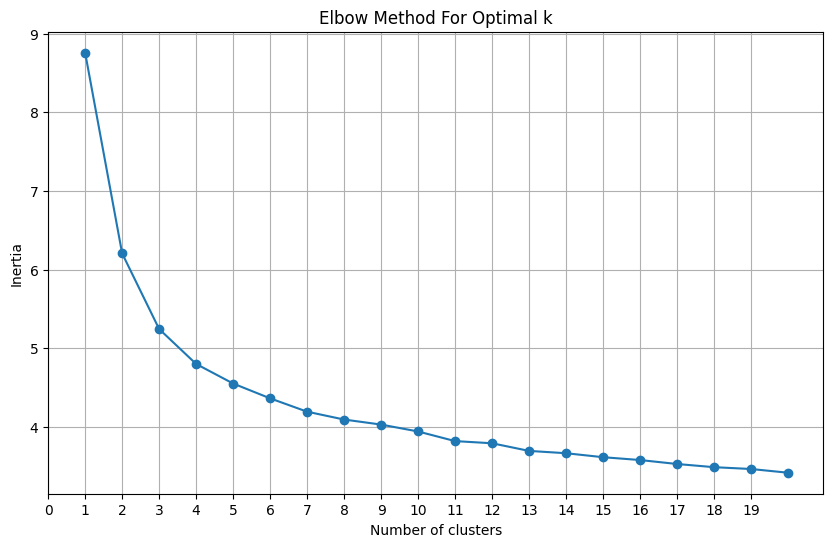

In [34]:
elbow_clustering_plot(normalized, 20)

np.random.seed(41)
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(normalized)
saveLabels = pd.DataFrame(labels, columns=['Label'])
saveLabels.to_csv('data/Cluster_labels_2.csv', header=True, index=False)
inertia = kmeans.inertia_

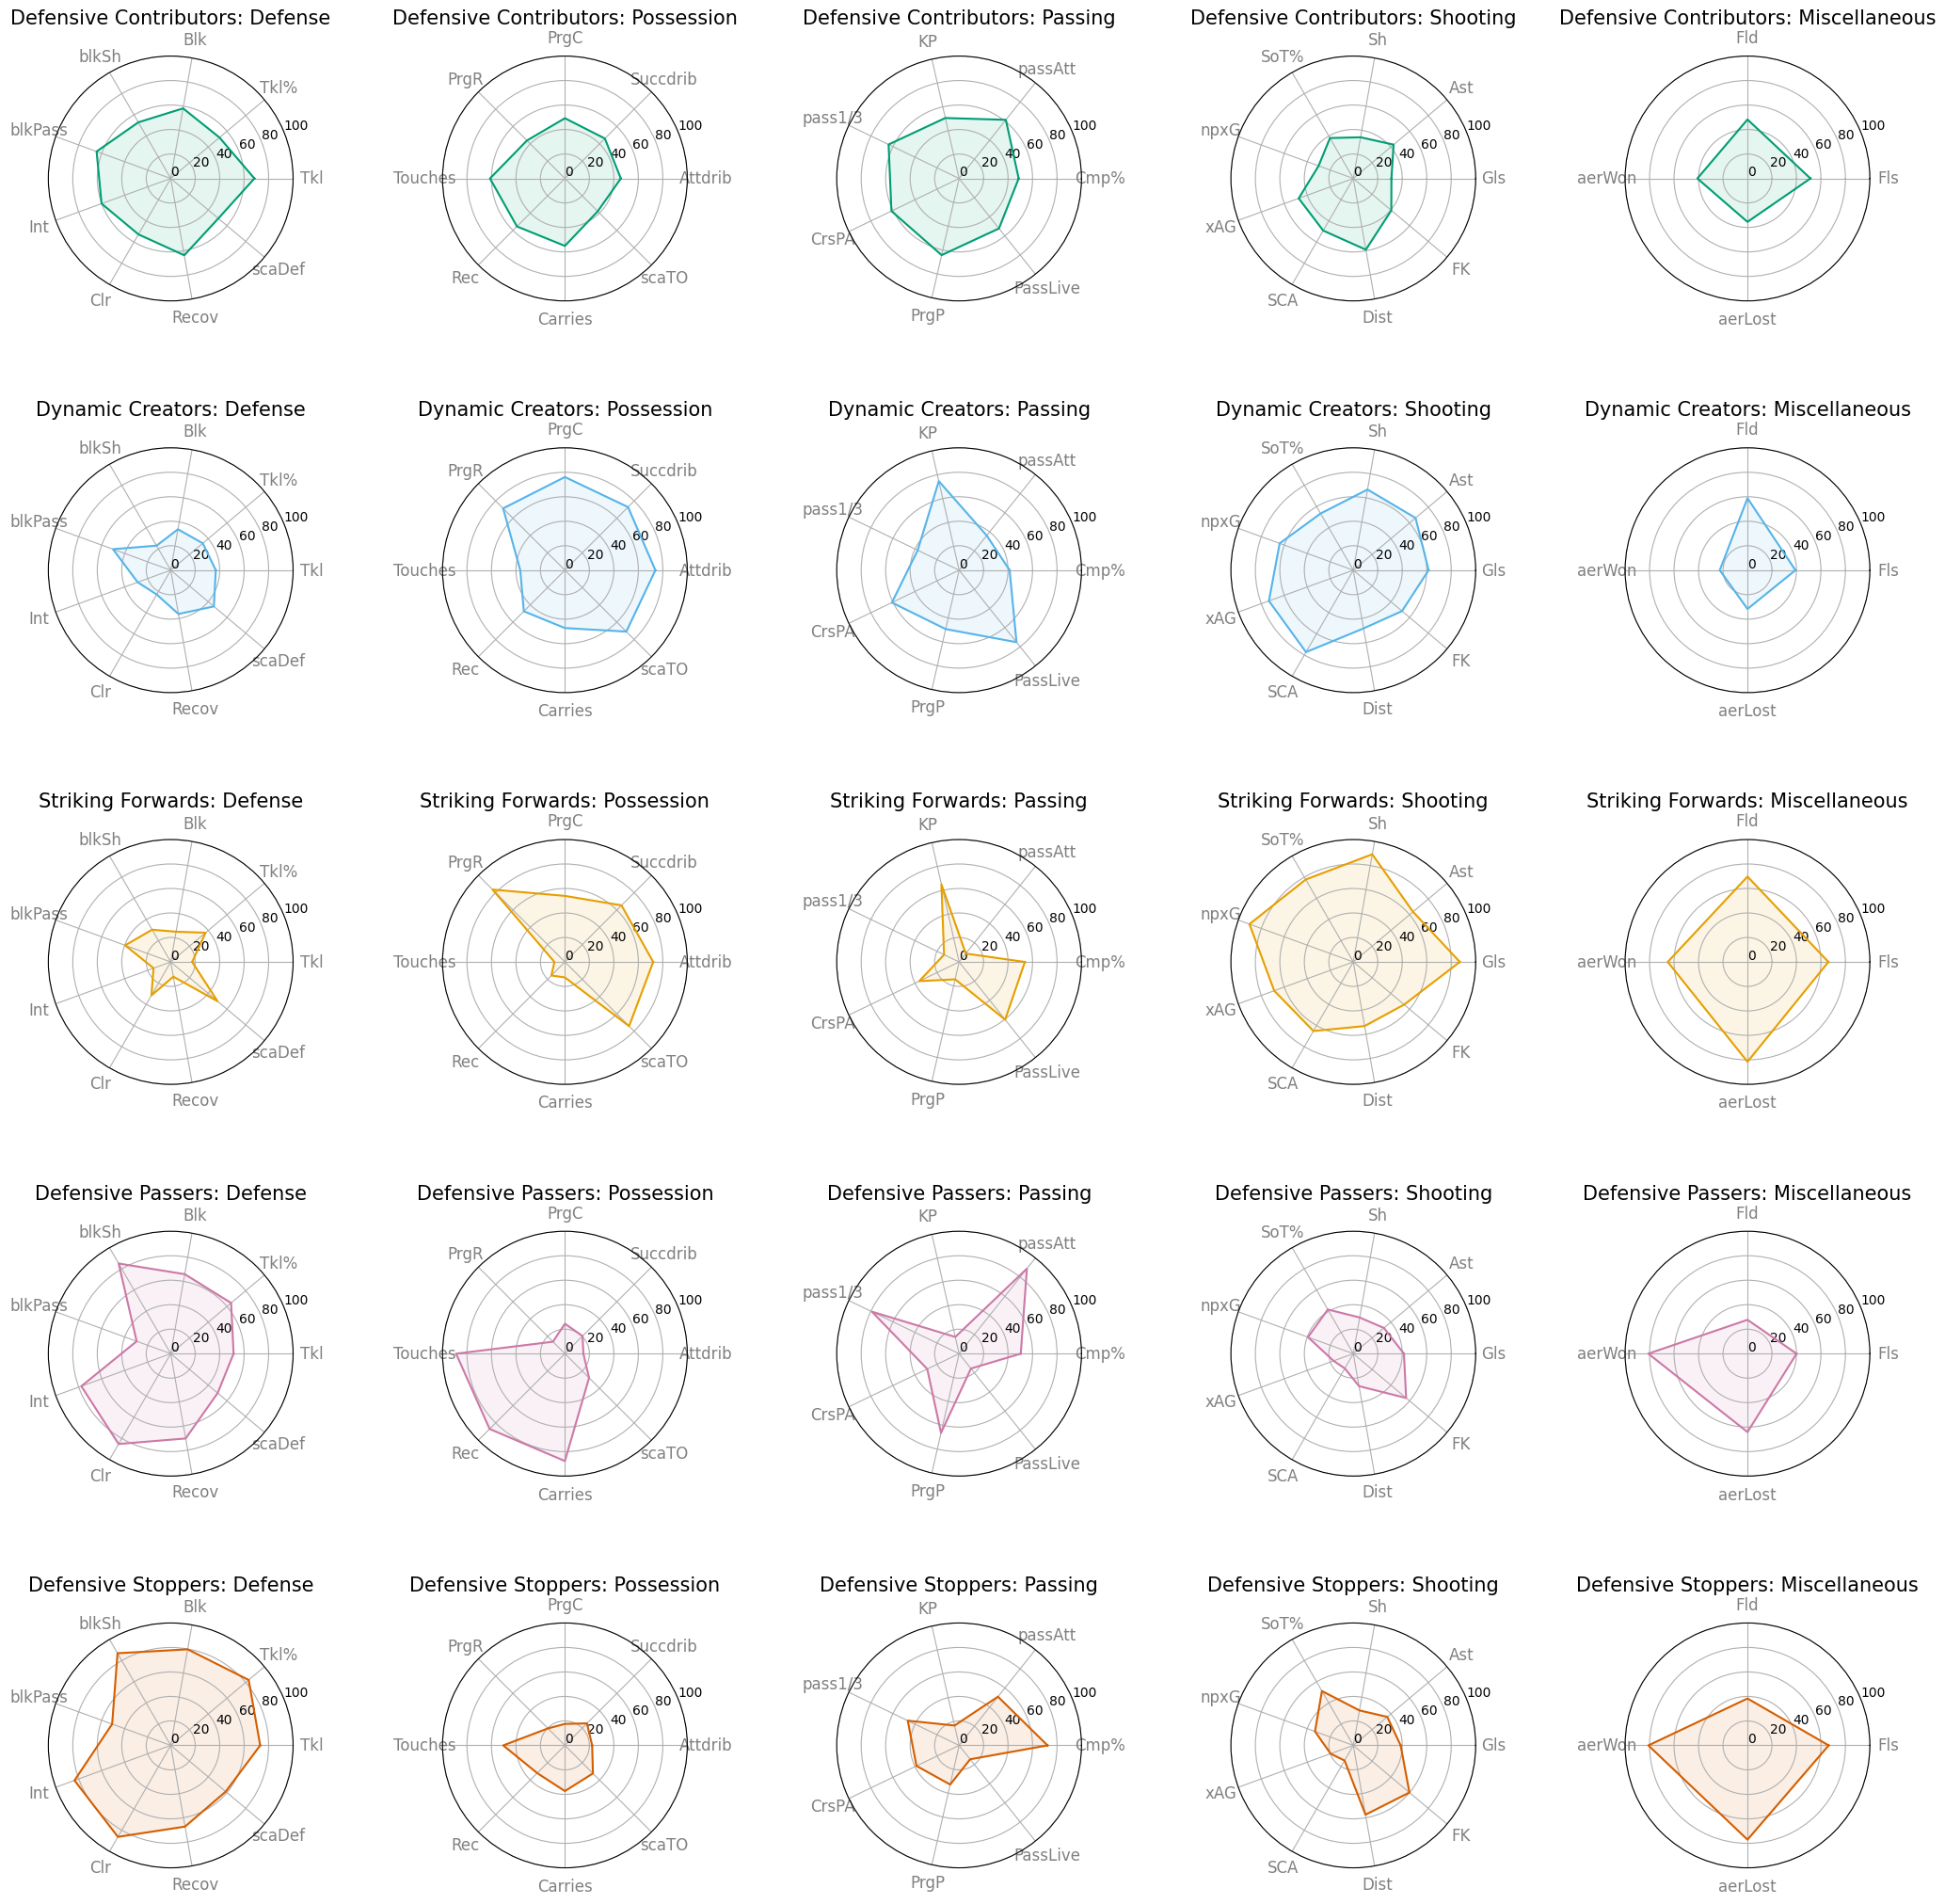

In [35]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Convert each value in the array to its percentile rank within its column
percentiles = np.apply_along_axis(lambda x: rankdata(x, method='average') / len(x) * 100, axis=0, arr=normalized)

# Create a DataFrame from the numerical data
percentiles = pd.DataFrame(percentiles, columns=cols)

# Define number of clusters and categories
num_clusters = 5
num_categories = len(categories)
fig, axes = plt.subplots(num_clusters, num_categories, figsize=(num_categories * 5, num_clusters * 5), subplot_kw=dict(polar=True))

# Adjust spacing if necessary
plt.subplots_adjust(hspace=0.6, wspace=0.6)
cluster_titles = ['Defensive Contributors', 'Dynamic Creators', 'Striking Forwards', 'Defensive Passers', 'Defensive Stoppers']
# Loop through each cluster and each category
for i in range(num_clusters):
    for j, (category_name, variables) in enumerate(categories.items()):
        ax = axes[i, j] if num_clusters > 1 and num_categories > 1 else axes[max(i, j)]
        cluster_df = percentiles[labels == i]
        plot_radial_chart(cluster_df, variables, ax, f"{cluster_titles[i]}: {category_name}", colors[2-i])

plt.show()

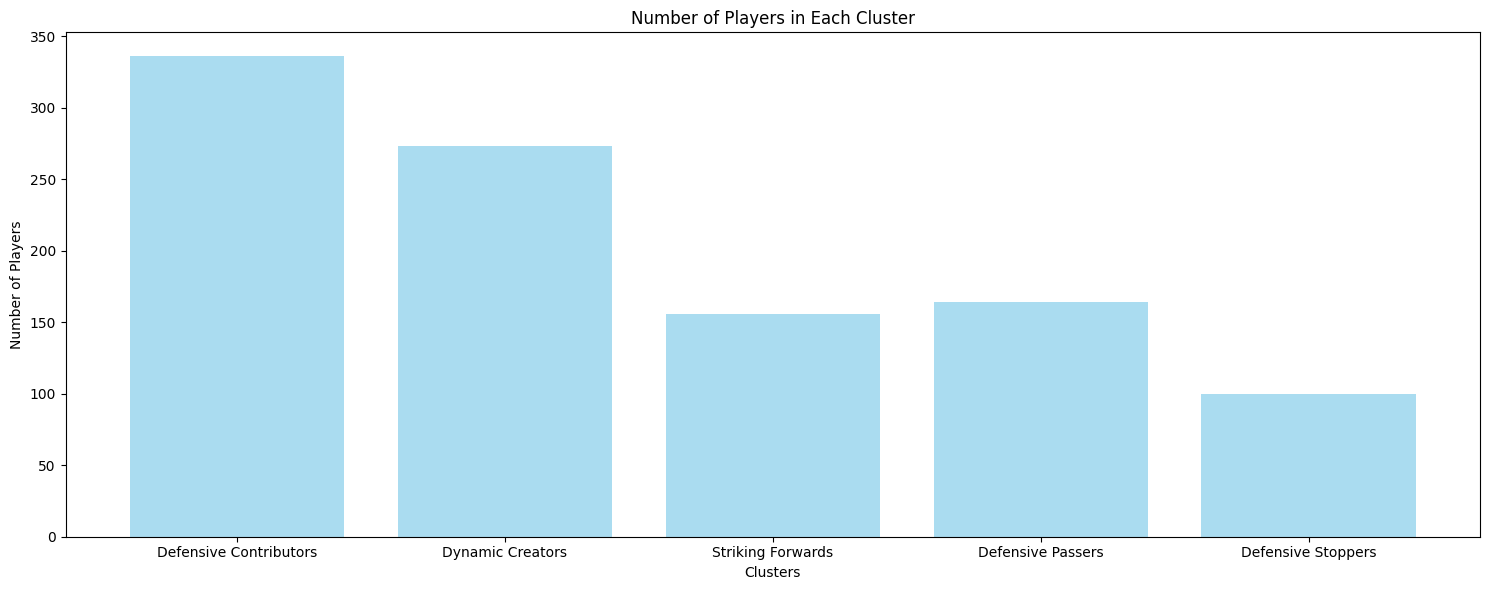

In [36]:
# Assuming 'saveLabels' is a pandas Series with the cluster names
# Get the value counts of the clusters
labels = pd.DataFrame(labels, columns=['Label'])
cluster_counts = labels['Label'].value_counts()

# Extract the labels and counts from cluster_counts
cluster_labels = cluster_counts.index.tolist()  # This should be a list of strings (cluster names)
num_players = cluster_counts.values  # This should be an array or a list of integers (counts)

# Create a bar chart
plt.figure(figsize=(15, 6))
plt.bar(cluster_labels, num_players, color='skyblue', align='center', alpha=0.7, capsize=5)
plt.axhline(y=0, linestyle='--', color='grey', linewidth=0.7)

# Assuming the labels are in the correct order, otherwise adjust as needed
plt.xticks(range(len(cluster_labels)), cluster_titles)

plt.xlabel('Clusters')
plt.ylabel('Number of Players')
plt.title('Number of Players in Each Cluster')

plt.tight_layout()
plt.show()

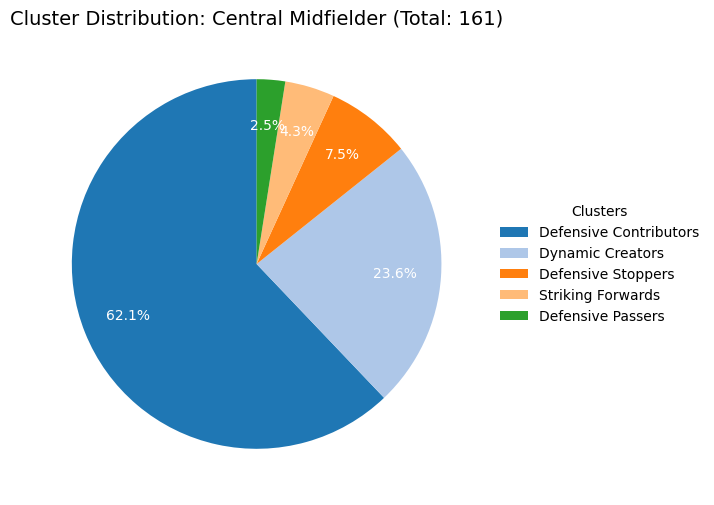

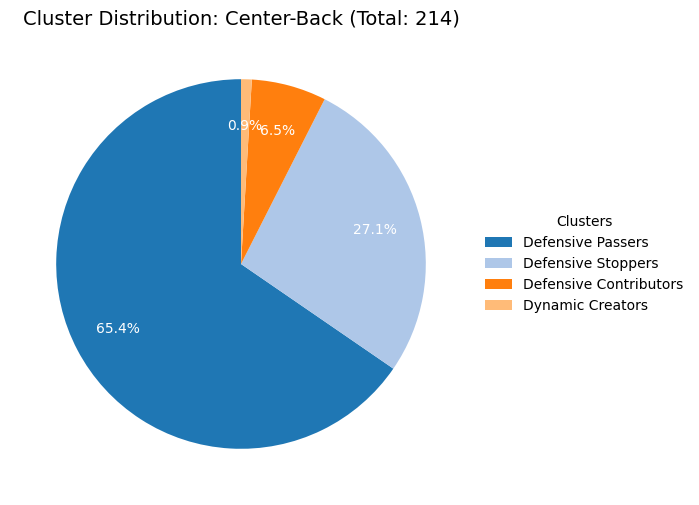

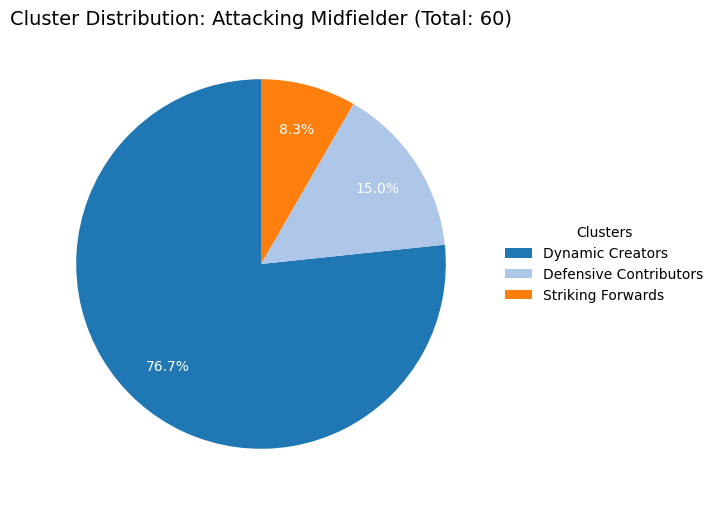

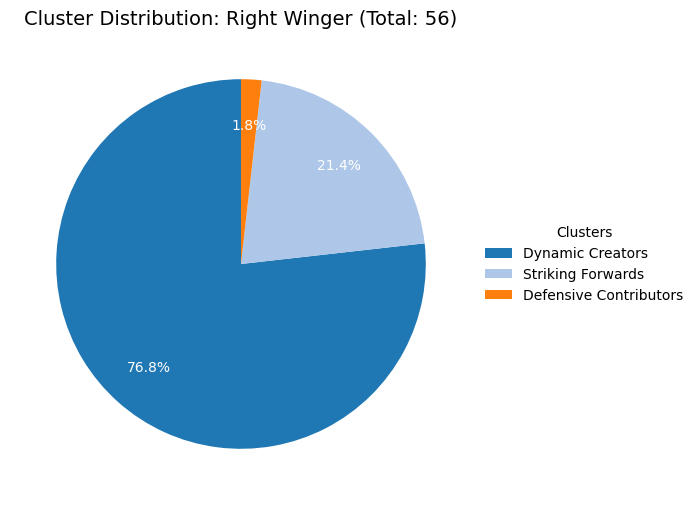

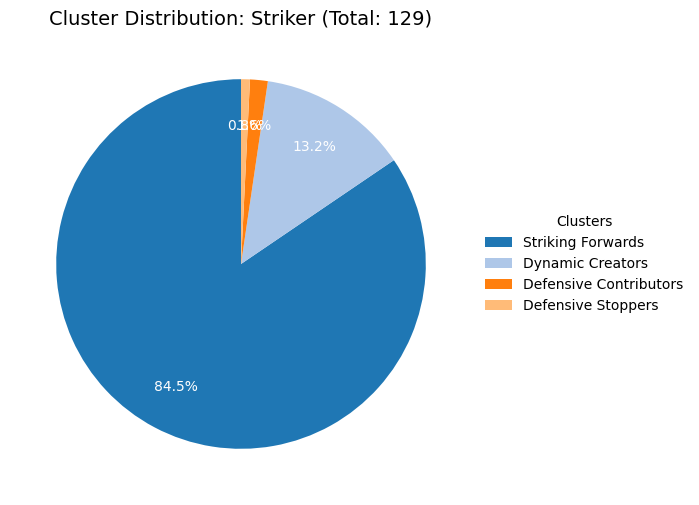

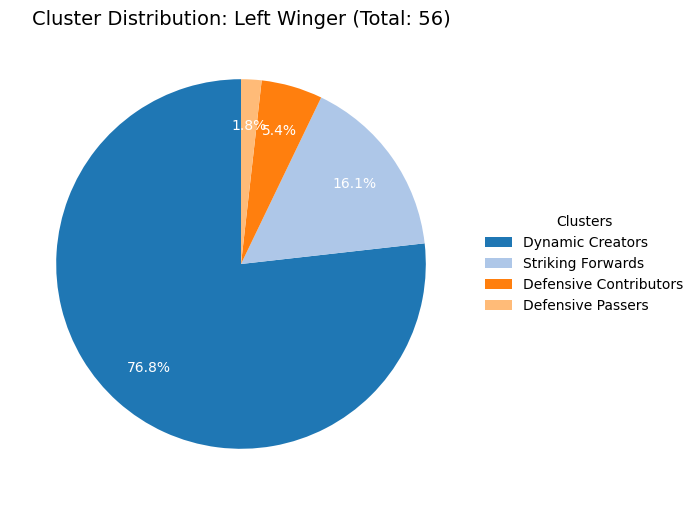

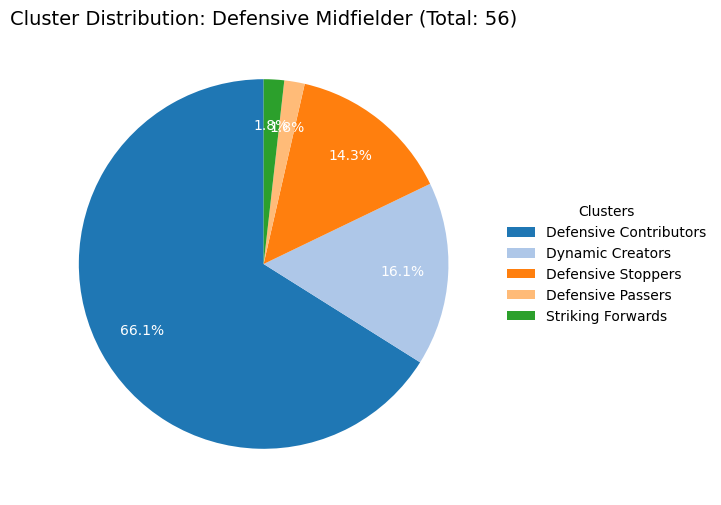

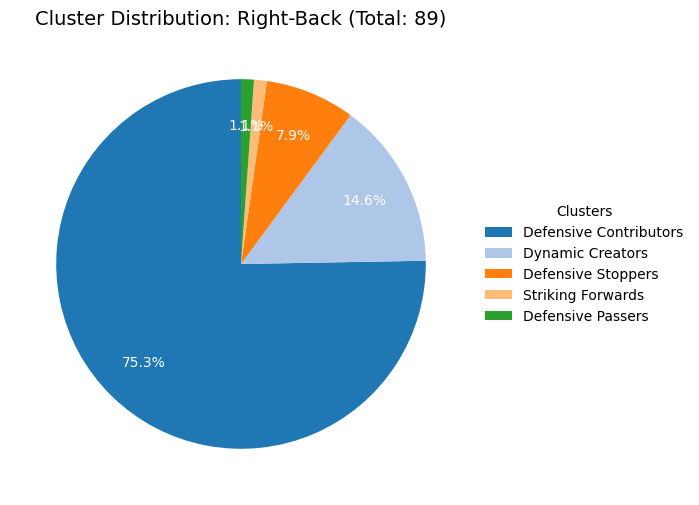

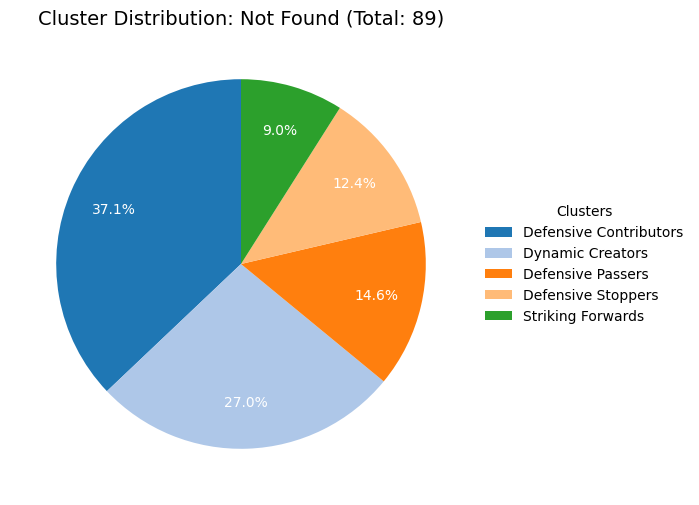

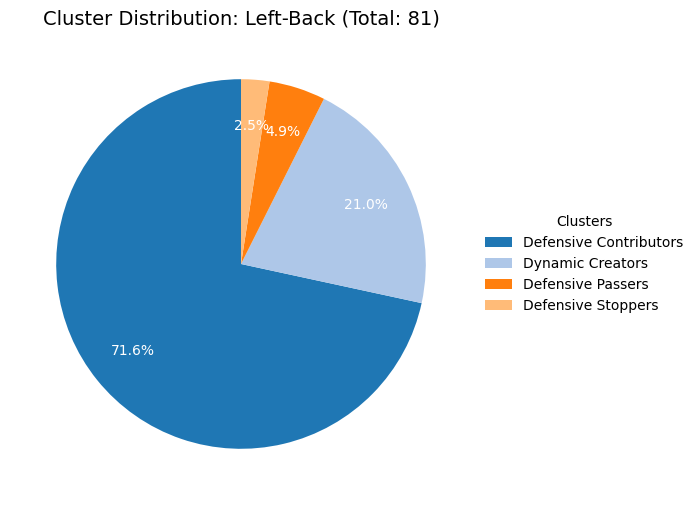

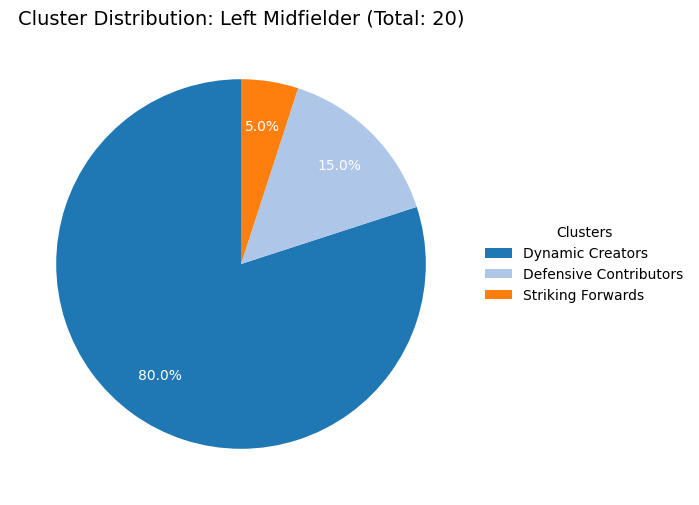

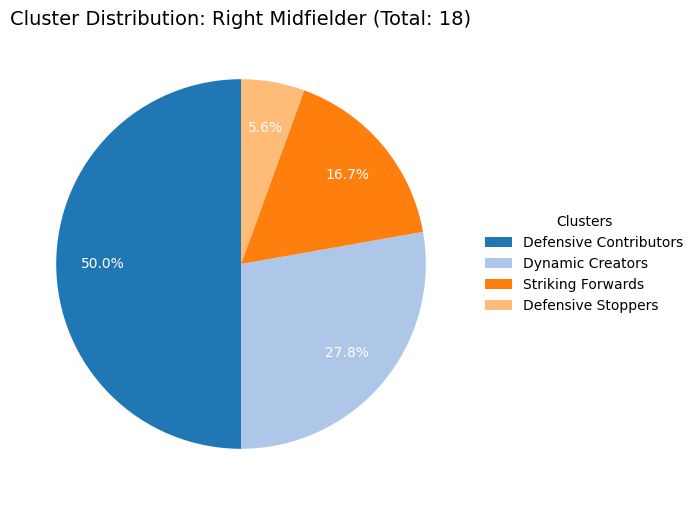

In [38]:
plot_position_cluster_distribution(playerdata['Position'], labels['Label'], cluster_titles)